# 0. Problems with symmetries in machine learning (ML)

Consider a simple machine learning task of predicting electric field from charge distribution. It is very straight forward for us, humans, to infer the field at point $p$ in situation $B$ (translated), $C$ (rotated), and $D$ (inverted) given the field in situation $A$ (original) because of the symmetries of Coulomb's law.

<img src='https://drive.google.com/uc?export=view&id=1px5iPU9W5T9m4dhyqCNiMUwA7MbfLhmT' width='800'/>

However, it is not so obvious for a normal ML model since it considers these four situations as entirely separated cases. There are, generally, three possible ways to solve this issue.

1.   **Data saturation**: Having large enough dataset that the model can separately learn to predict the field in each situation.
2.   **Data augmentation**: Apply all considered transformations to each of the data point in the dataset and add the transformed data as additional data points.
3.   **Equivariant model**: Design the model architecture that implicitly taking care of the symmetries.



Although, there are use cases for each method, we are considering the problems where it is hard to acquire enough data to obtain data saturation, and the data augmentation provide too many data points to trained effectively. The first criterion always happen when we want to train the model on experimental or resource intensive simulation data. The second one can happen when there are too many transformations, e.g., three dimensional (3D) rotation with 3.6$^\circ$ resolution has about $10^6$ transformations to augment per data point. Hence, the only viable option is equivariant model.

# 1. Equivariant model and Group Representation

Consider an ML model $M$ that predict output $y=M(x)$ (e.g., electric field at each point in space) from input $x$ (e.g., charge density at each point in space). $M$ is an equivariant model with respect to a transformation $G$ (e.g., translation, rotation, and inversion) means that, if the input got transformed by $g\in G$, the model will predict the output that is equivalent to applying transformation $g$ to $M(x)$, i.e.,
$$M(g(x)) = g(M(x)).$$

<img src='https://drive.google.com/uc?export=view&id=1cw2MRahXKKTe0mFQwiDBR-JHhK6E19lD' width='800'/>

One can also notice that the transformation by $g$ is not the same for different objects. For example, in the above diagram where $g$ is a 2D rotation on the plane, while the charge values stay invariant of the transformation, the electric field direction at point $p$ got rotated. This means that electric field, and charge have different representations under the transformation $G$. However, to understand representation, we need to introduce the concept of group. Since this is not a formal introduction of group, and representation theory, we will not go over any mathematical proof.

As a concrete example, let's look back at the electric field, and charge. Both of them are transformed by the same rotation of 2D rotation group but with different representations. We will decorate $D^{(E)}$, and $D^{(c)}$ for representations of electric field, and charge, respectively.

<img src='https://drive.google.com/uc?export=view&id=13jOxXAnFkTRv-3XI6xhKx4iIF2HN_8EG' width='800'/>

It is straight forward in this case because we know that charge is a scalar value that invariant to rotation, and electric field is a 3D vector that rotate by 3 by 3 rotation matrices. However, once the information got passed down the layers, for example of deep neural network model, it is not so easy to track the representations of every object. Hence, the creation of many python libraries that automatically track the representation for us. In this tutorial, we are focusing on e3nn, a python library for managing model to be equivariant to 3D Euclidean group, $E(3)$, which include 3D translation, rotation, and inversion.

# 2. Install e3nn library








In [ ]:
!pip install e3nn

# 3. Get start with e3nn

There is also a sub-version of e3nn that utilize jax library for a more efficient training. However, we are going to use the normal version with pytorch as the training manager. Also, it is not recommended to directly download the package from github page since the main branch is under active development.

## e3nn library overview

o3: Module for O(3) Group Operations
   - Parametrization of Rotations
   - Irreps (Irreducible Representations)
   - Tensor Product
   - Spherical Harmonics

nn: Module for Neural Network Components
   - Gate
   - Fully Connected Neural Network
   - Batch Normalization
   - Spherical Activation
   - Norm-Based Activation

io: Module for Utility Classes for Spherical Signals and Cartesian Tensors
   - Spherical Tensor
   - Cartesian Tensor

## Import pytorch, numpy, and e3nn libraries

In [ ]:
import torch

In [ ]:
torch.__version__

'2.3.0+cu121'

In [ ]:
import numpy as np

In [ ]:
np.__version__

'1.25.2'

In [ ]:
import e3nn
import e3nn.o3 as o3
import e3nn.io as io

In [ ]:
e3nn.__version__

'0.5.1'

Set default data type to 64 bit float.

In [ ]:
torch.set_default_dtype(torch.float64)

Set default data printing to be in decimals.

In [ ]:
torch.set_printoptions(sci_mode = False, linewidth = 200)

Ignore some warning from pytorch due to some attribute handling in e3nn. We do this for the cleaness of the notebook only, not for use in actual project.

In [ ]:
import warnings

warnings.filterwarnings('ignore')

# 4. Irreducible Representation (Irrep)

We already introduced the concept of group representation, and that is actually enough to make a model equivariant. However, decomposing the representation down to irreducible parts make a model much more efficient in term of tracking the representation at each layer as well as ignoring the calculation paths that lead to the output with different representation from the output. For example, the path that end up with multiplication of two scalars, which gives scalar output, should not be included in electric field (vector) prediction. Furthermore, there is actually a deep connection between irrep, and the structure of the group. However, it is not in the scope of this tutorial.

In e3nn, the irreducible representations (irreps) are parametrized by two parameters $l\in \{0, 1, 2, \cdots\}$ representing rotation order, and $p\in \{e, o\}$ representing parity. For example,
- $0e$ represents scalar
- $0o$ represents pseudo-scalar
- $1e$ represents pseudo-vector
- $1o$ represents vector
- $\cdots$

## e3nn Irreps for irrep

Let's see some simple examples to demonstrate what we have discussed so far. First define a scalar, and a vector representations

In [ ]:
irreps_0e = o3.Irreps('0e')
irreps_1o = o3.Irreps('1o')

Randomly generate the scalar, and vector objects from the irreps objects. Since the irreps are for scalar, and vector. The randomly generated data are 1D, and 3D objects, respectively. In fact, irreps with parameter $l$ has $2l+1$ dimensions.

In [ ]:
x_0e = irreps_0e.randn(-1)
x_1o = irreps_1o.randn(-1)
print('x_0e: ', x_0e)
print('x_1o: ', x_1o)

x_0e:  tensor([-1.2019])
x_1o:  tensor([-0.9228,  0.0297,  1.8239])


Suppose we want to transform these two objects by rotating the space around $(0, 0, 1)$ direction by 30$^\circ$ follow by inverting the space. Since a scalar is rotation invariant, and has even parity, the representation of this transformation should be an identity. Meanwhile, the vector representation should be a rotation matrix
$$-\dfrac{1}{2}\begin{bmatrix}
\sqrt{3} & -1 & 0 \\
1 & \sqrt{3} & 0 \\
0 & 0 & 2
\end{bmatrix}
\approx \begin{bmatrix}
-0.866 & 0.500 & 0.000 \\
-0.500 & -0.866 & 0.000 \\
0.000 & 0.000 & -1.000
\end{bmatrix}$$
where the preceeding negative come from the odd parity of a vector. We can check that e3nn give the correct transformation matrices. E3nn has a number of functions in irreps class, which can easily be used to generate rotation matrices.

In [ ]:
#D_from_axis_angle generates rotation matrix given rotational axis and angle around that axis.
#D_from_angles generates rotation matrix from Euler angle
D_0e = irreps_0e.D_from_angles(*torch.tensor([0, 0, 0, 1])) @ irreps_0e.D_from_axis_angle(torch.tensor([0.0, 0.0, 1.0]), torch.tensor(30.0*np.pi/180))
D_1o = irreps_1o.D_from_angles(*torch.tensor([0, 0, 0, 1])) @ irreps_1o.D_from_axis_angle(torch.tensor([0.0, 0.0, 1.0]), torch.tensor(30.0*np.pi/180))

In [ ]:
print('D_0e: ')
print(D_0e)
print('\nD_1o: ')
print(D_1o)

D_0e: 
tensor([[1.]])

D_1o: 
tensor([[    -0.8660,      0.5000,      0.0000],
        [    -0.5000,     -0.8660,      0.0000],
        [    -0.0000,      0.0000,     -1.0000]])


## e3nn Irreps for multiple irreps

As shown in the electric field prediction case, the input can contain multiple objects each with its irreducible representation. We can also use e3nn o3.Irreps for this case as well. In e3nn, we use '+' between two diffrent irreps for their combination. We also use 'x' for multiple of irreps of the same type. For example, if we want to represent the input for the electric field prediction with 2 input charge locations, the representation needs to contain 2 scalars, and 2 vectors.

In [ ]:
irreps_2_charges = o3.Irreps('2x0e+2x1o')

Randomly generate the objects from the irreps object. Since the irreps are for 2 scalars, and 2 vectors. The randomly generated data has 8 dimensions.

In [ ]:
x_2_charges = irreps_2_charges.randn(-1)
print('x_2_charges: ', x_2_charges)

x_2_charges:  tensor([ 0.1826, -0.6634, -1.3637, -0.5872, -0.9194, -1.0352,  0.4541,  0.6507])


Suppose we want to transform this object by the same transformation as before. Because this object contain 2 scalars, and 2 vectors, we should expect the transformation matrix to be 4-block-diagonal with 2 1D identity blocks, and 2 3D rotation blocks each is the same as the one for irreps_1o. We can check that e3nn give the correct transformation matrices.


In [ ]:
D_2_charges = irreps_2_charges.D_from_angles(*torch.tensor([0, 0, 0, 1])) @ irreps_2_charges.D_from_axis_angle(torch.tensor([0.0, 0.0, 1.0]), torch.tensor(30.0*np.pi/180))
print('D_2_charges: ')
print(D_2_charges)

D_2_charges: 
tensor([[     1.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      1.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,     -0.8660,      0.5000,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,     -0.5000,     -0.8660,      0.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,     -0.0000,      0.0000,     -1.0000,      0.0000,      0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,     -0.8660,      0.5000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,     -0.5000,     -0.8660,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,     -0.0000,      0.0000,     -1.0000]])


# 5. Tensor Product

From irreps section, we can see that, apart from angular momentum, there are not many physical objects that can be represented by $l\geq 2$. Likewise, there are also many physical objects, e.g., stress tensor, conductivity, etc., that cannot be represented by an irrep. This is simply because their representations are reducible, i.e., can be decomposed into multiple irreps.

## Tensor Product as Representation building block

Consider the case where we want to represent electric susceptibility $\chi_{ij}$, since this matrix connects electric field (vector) to polarization density (vector), and polarization equation should be invariant, the electric susceptibility must transform each of the indices as a vector. This combined transformation is denoted with a tensor product ($\otimes$) between two irreps. For example, electric susceptibility's representation is
$$1o\otimes 1o$$
which is reducible into
$$0e + 1e + 2e.$$
In other words, the representation of electric susceptibility can be decomposed into three irreps. Note that the total dimension of $0e + 1e + 2e$ is $1+3+5=9$ which is exactly the number of components in $\chi$. Hence, there is no information loss from the decomposition.

For 3D matrices like electric susceptibility, there is actually a good interpretation for the decomposition into the trace, anti-symmetric, and traceless-symmetric part of the matrices.

To see that this is the case in e3nn, consider its tensor product module between two vector irreps.

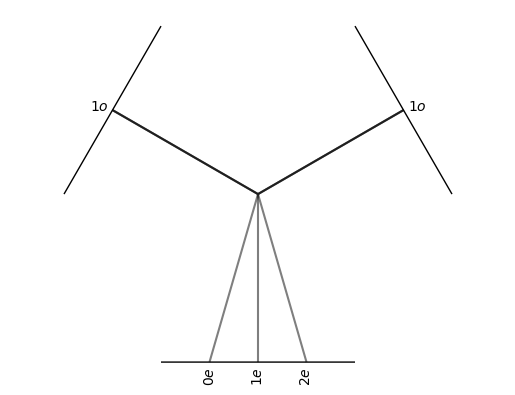

In [ ]:
tp_1o_1o = o3.FullTensorProduct('1o', '1o')
_ = tp_1o_1o.visualize()

## Tensor Product as Angular Momentum Addition

From the previous section, one might recognize the algebra of tensor product, and those number combinations in the probing table from when we perform angular momentum quantum number addition. In fact, they are actually the same since angular momentum is the generator of 3D rotations. Hence, the degenerated eigenstates of angular momentum operator are of the same irreps, and the probing matrix contains Clebsch-Gordan coefficients for angular momentum addition. Note that the basis used in e3nn is real sperical harmonic instead of complex for computational efficiency. This makes Clebsch-Gordan coefficients slightly different from the one commonly used in quantum mechanics.

This means that it is straight forward to decompose representations into multiple irreps by using the knowledge of angular momentum addition, i.e., keep track of irreps in each layer, and perform angular momentum addition when ever there are tensor product such that
$$l_1\pi_1 \otimes l_2\pi_2 = \sum_{l=|l_1-l_2|}^{l_1+l_2} l(\pi_1\cdot \pi_2)$$
where, for parity, the multiplication gives $e$ if $\pi_1$ is the same as $\pi_2$, otherwise $o$. This is basically what e3nn automates the process for us.

Let's see some examples to see that this is the case.

1. $5o\otimes 2e$ should give $l = 3, 4, 5, 6, 7$ with odd parity.

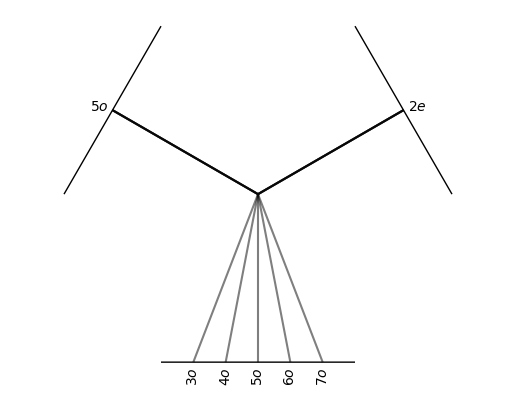

In [ ]:
tp_5o_2e = o3.FullTensorProduct('5o', '2e')
_ = tp_5o_2e.visualize()

2. The addition of 3 spin-1 values should gives the following irreps with even parity.
$$1e\otimes 1e\otimes 1e = (0e+1e+2e)\otimes 1e = 1e+(0e+1e+2e)+(1e+2e+3e)$$

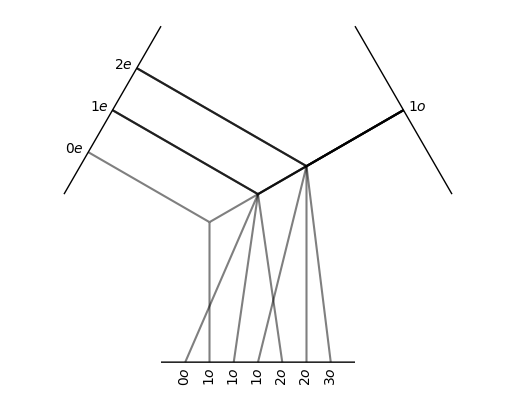

In [ ]:
irreps_1o_1o = tp_1o_1o.irreps_out
tp_1o_1o_1o = o3.FullTensorProduct(irreps_1o_1o, '1o')
_ = tp_1o_1o_1o.visualize()

## Other features of tensor product in e3nn

The tensor product module in e3nn is designed to be very flexible. Users can actually input their instructions like selection rules, channel controls, and weight sharing. However, unless we want to perform a complex task like interpretable machine learning, it is not necessary to micro manage the tensor product module behavior. We can just use the pre-define functions e3nn provided. The following are some useful features that one might use in machine learning.

### a. Irreps filtering

There are cases where we don't want all of the irreps from tensor product to be use in the learning especially for the irreps with large $l$ since they are most likely related to higher order terms making low contribution to the model accuracy, with large training cost due to its memory consumption.

Consider the case for tensor product between $1e$, and $1e$ irreps. We should expect $0e+1e+2e$ as the tensor product output, but we can filter out some irreps.

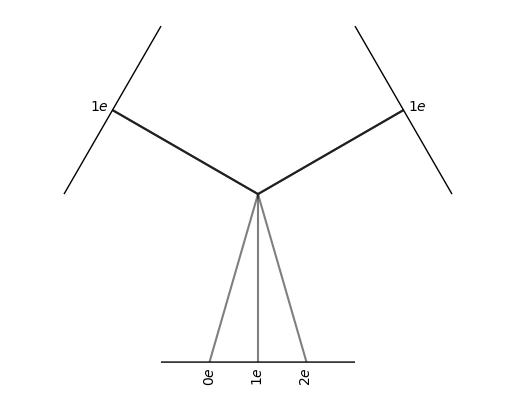

In [ ]:
tp_1e_1e_full = o3.FullTensorProduct('1e', '1e')
_ = tp_1e_1e_full.visualize()

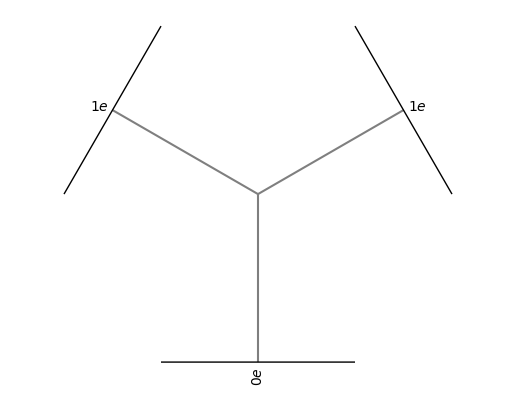

In [ ]:
tp_1e_1e_only_0e = o3.FullTensorProduct('1e', '1e', ['0e'])
_ = tp_1e_1e_only_0e.visualize()

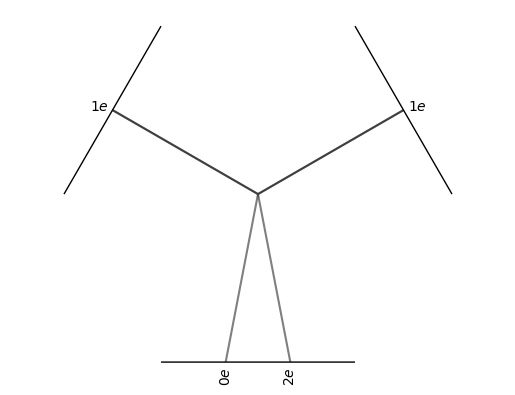

In [ ]:
tp_1e_1e_no_1e = o3.FullTensorProduct('1e', '1e', ['0e', '2e'])
_ = tp_1e_1e_no_1e.visualize()

We can also see how the feature works out on real inputs.

In [ ]:
x1 = torch.tensor([1.0, 2.0, 3.0])
x2 = torch.tensor([4.0, 5.0, 6.0])
print('Full tensor product:')
print(tp_1e_1e_full(x1, x2))
print('\nFiltered 0e channel:')
print(tp_1e_1e_only_0e(x1, x2))
print('\nFilter out 1e channel:')
print(tp_1e_1e_no_1e(x1, x2))

Full tensor product:
tensor([18.4752, -2.1213,  4.2426, -2.1213, 12.7279,  9.1924, -0.8165, 19.0919,  9.8995])

Filtered 0e channel:
tensor([18.4752])

Filter out 1e channel:
tensor([18.4752, 12.7279,  9.1924, -0.8165, 19.0919,  9.8995])


### b. Tensor product details, and visualization

e3nn offers a nice object string representation, and visualization. Consider a complex tensor product between $32\times 1o+32\times 0e$ and $0e+1o$.

In [ ]:
tp_32x1o32x0e_0e1o = e3nn.o3.FullTensorProduct('32x1o+32x0e', '0e+1o')

One can see the instance detail by print the object out. We can see the inputs,and the tensor product irreps, as well as the number of computational paths, i.e., how many single irrep-irrep tensor products. This will be used when we want to apply learnable weights to each path in a machine learning model.

In [ ]:
tp_32x1o32x0e_0e1o

FullTensorProduct(32x1o+32x0e x 1x0e+1x1o -> 64x0e+64x1o+32x1e+32x2e | 192 paths | 0 weights)

As shown many times through out this section, we can also visualize the tensor product instance.

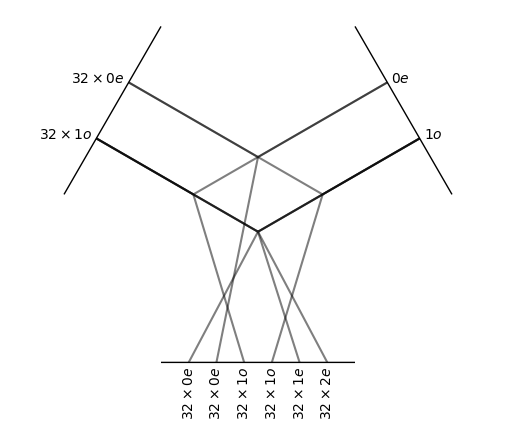

In [ ]:
_ = tp_32x1o32x0e_0e1o.visualize()

### c. Element-wise tensor product

In the case where we don't want to apply tensor product irrep by irrep. From the following example, we can see that, there are 10 irreps for each input, and only 20 tensor product paths are considered. This number got contributed by four scalar-scalar products (1 each), one scalar-pseudo-vector products (1 each), and five pseudo-vector-pseudo-vector products (3 each).

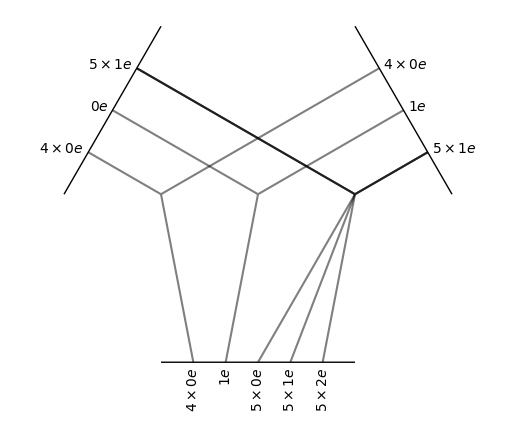

In [ ]:
tp_element = o3.ElementwiseTensorProduct('5x0e + 5x1e', '4x0e + 6x1e')
_ = tp_element.visualize();

In [ ]:
tp_element

ElementwiseTensorProduct(5x0e+5x1e x 4x0e+6x1e -> 4x0e+1x1e+5x0e+5x1e+5x2e | 20 paths | 0 weights)

### d. Reduced tensor product

One can further impose some symmetries into the tensor product path selection. The following is an example for extracting only the symmetric or anti-symmetric path from the full tensor product between two vectors.

In [ ]:
irreps_in = o3.Irreps('1o')
tp = o3.FullTensorProduct(irreps_in, irreps_in)
rtp_sym = o3.ReducedTensorProducts('ij=ji', i = irreps_in)
rtp_anti_sym = o3.ReducedTensorProducts('ij=-ji', i = irreps_in)

In [ ]:
tp

FullTensorProduct(1x1o x 1x1o -> 1x0e+1x1e+1x2e | 3 paths | 0 weights)

As previously discussed, the irreps of tensor product of two vectors composes of $0e$ and $2e$ (trace, and traceless symmetric) which are symmetric parts, and $1e$ (anti-symmetric) which is anti-symmetric part. We can directly see the reduced tensor product selects the parts according to the supplied rules ('ij=ji', or 'ij=-ji).

In [ ]:
rtp_sym

ReducedTensorProducts(
    in: 1x1o times 1x1o
    out: 1x0e+1x2e
)

In [ ]:
rtp_anti_sym

ReducedTensorProducts(
    in: 1x1o times 1x1o
    out: 1x1e
)

The channel selection also apply to the actual tensor product of two vectors. To explicitly see the equivalence, let consider a tensor product between $[1, 2, 3]$, and $[4, 5, 6]$. The resulting product need to be
$$\begin{bmatrix}
4 & 5 & 6 \\
8 & 10 & 12 \\
12 & 15 & 18
\end{bmatrix}.$$

One can decompose this matrix to
$$\dfrac{1}{3}\begin{bmatrix}
32 & 0 & 0 \\
0 & 32 & 0 \\
0 & 0 & 32
\end{bmatrix}+\dfrac{1}{2}\begin{bmatrix}
0 & -3 & -6 \\
3 & 0 & -3 \\
6 & 3 & 0
\end{bmatrix}+\dfrac{1}{6}\begin{bmatrix}
-40 & 39 & 54 \\
39 & -4 & 81 \\
54 & 81 & 44
\end{bmatrix}.$$

Combine the first, and last to get symmetric part
$$\dfrac{1}{2}\begin{bmatrix}
8 & 13 & 18 \\
13 & 20 & 27 \\
18 & 27 & 36
\end{bmatrix}+\dfrac{1}{2}\begin{bmatrix}
0 & -3 & -6 \\
3 & 0 & -3 \\
6 & 3 & 0
\end{bmatrix}.$$

In [ ]:
x1 = torch.tensor([1.0, 2.0, 3.0])
x2 = torch.tensor([4.0, 5.0, 6.0])

print('Input 1:')
print(x1)
print('\nInput 2:')
print(x2)

print('\nTensor Product:')
print(tp(x1, x2))
print('\nSymmetric Tensor Product:')
print(rtp_sym(x1, x2))
print('\nAnti-Symmetric Tensor product:')
print(rtp_anti_sym(x1, x2))

Input 1:
tensor([1., 2., 3.])

Input 2:
tensor([4., 5., 6.])

Tensor Product:
tensor([18.4752, -2.1213,  4.2426, -2.1213, 12.7279,  9.1924, -0.8165, 19.0919,  9.8995])

Symmetric Tensor Product:
tensor([18.4752, 12.7279,  9.1924, -0.8165, 19.0919,  9.8995])

Anti-Symmetric Tensor product:
tensor([-2.1213,  4.2426, -2.1213])


We can invert the probing matrix to transform back the irreps into matrix form.

In [ ]:
tr = 3 ** -0.5
tw = 2 ** -0.5
irrep2mat = torch.tensor([[    tr,  0,   0,   0,      tr,  0,  0,   0,     tr],
                          [     0,  0,   0,   0,       0, tw,  0, -tw,      0],
                          [     0,  0, -tw,   0,       0,  0, tw,   0,      0],
                          [     0, tw,   0, -tw,       0,  0,  0,   0,      0],
                          [     0,  0,  tw,   0,       0,  0, tw,   0,      0],
                          [     0, tw,   0,  tw,       0,  0,  0,   0,      0],
                          [-tw*tr,  0,   0,   0, 2*tw*tr,  0,  0,   0, -tw*tr],
                          [     0,  0,   0,   0,       0, tw,  0,  tw,      0],
                          [   -tw,  0,   0,   0,       0,  0,  0,   0,     tw]], dtype = torch.float64)

For full tensor product, the matrix is as following.

In [ ]:
torch.matmul(tp(x1, x2), irrep2mat).view(3, 3)

tensor([[ 4.0000,  5.0000,  6.0000],
        [ 8.0000, 10.0000, 12.0000],
        [12.0000, 15.0000, 18.0000]])

For symmetric part.

In [ ]:
torch.matmul(rtp_sym(x1, x2), irrep2mat[[0, 4, 5, 6, 7, 8]]).view(3, 3)

tensor([[ 4.0000,  6.5000,  9.0000],
        [ 6.5000, 10.0000, 13.5000],
        [ 9.0000, 13.5000, 18.0000]])

And for anti-symmetric part.

In [ ]:
torch.matmul(rtp_anti_sym(x1, x2), irrep2mat[[1, 2, 3]]).view(3, 3)

tensor([[ 0.0000, -1.5000, -3.0000],
        [ 1.5000,  0.0000, -1.5000],
        [ 3.0000,  1.5000,  0.0000]])

## Tensor Product as Neural Network building block: Why need Tensor Product?

Tensor product provide a building block for combining two irreps of the previous layer into new irreps of the next layer of the model. However, so far, there is no free parameter/weight for a model to learn. To see how, it is best to compare with normal neural network as the baseline.

Consider a fully connected layer, i.e., linear layer without bias. In normal neural network, the layer basically apply weight as linear combination of all possible input instances as shown in the top image. However, in the following image, the input composed of two irreps, but we cannot perform linear combination learning as in the first case since we cannot add objects of different irreps together, e.g., it make no sense adding charge value to electric field in x direction.

<img src='https://drive.google.com/uc?export=view&id=1wixqSLpt0SMot0qYQeeteSV73Zh6QoZ-' width='500'/>

Instead, we could do linear combination separately for each irrep type of scalars and vectors.

<img src='https://drive.google.com/uc?export=view&id=15PLnv6axWdQJWGnmAv2UFQNkuv1W3V7L' width='500'/>

But this is not so good in terms of learning something useful without information passing between different data types. For example, we should expect the electric field to be a combined learning between charges ($0e$), and coordinates ($1o$), instead of only coordinates which are the same irreps as electric field ($1o$). Since tensor product can naturally combine objects of two irreps into a new one without breaking the equivariance features, it is natural to utilize it as the building block for equivariant model.

<img src='https://drive.google.com/uc?export=view&id=1wFW9ruTTU-Fi5ZGSCnN1tOTS1Y22mpfs' width='800'/>

Let's see the above example in e3nn. First, for comparison, see the tensor product between two $0e+1o$'s. It should give use the combined irreps of $0e+1o+1o+0e+1e+2e$.

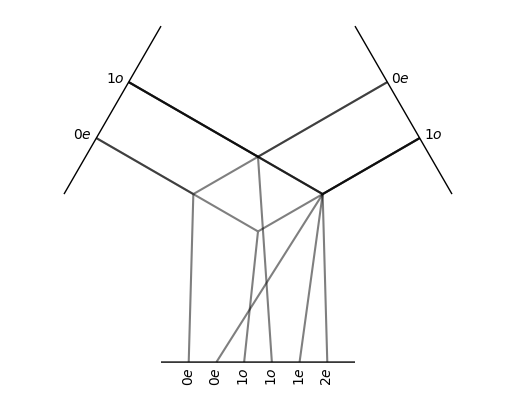

In [ ]:
tp = o3.FullTensorProduct('0e+1o', '0e+1o')
_ = tp.visualize()

In [ ]:
tp

FullTensorProduct(1x0e+1x1o x 1x0e+1x1o -> 2x0e+2x1o+1x1e+1x2e | 6 paths | 0 weights)

From these, there are only two $0e$, and two $1o$ that have common irreps as the desired output $0e+1o$, output electrical field with strength $0e$ and direction $1o$. Hence, this linear layer can only have 4 linear combination weights: 2 from $0e$, and 2 from $1o$ as shown in the figure. The e3nn module that handle this is fully connected tensor product.

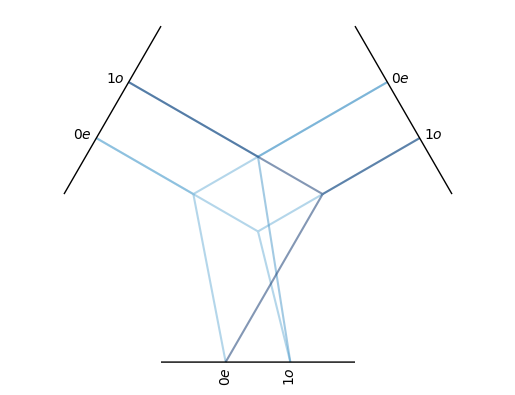

In [ ]:
fct = o3.FullyConnectedTensorProduct('0e+1o', '0e+1o', '0e+1o')
_ = fct.visualize()

In [ ]:
fct

FullyConnectedTensorProduct(1x0e+1x1o x 1x0e+1x1o -> 1x0e+1x1o | 4 paths | 4 weights)

# 6. Toy Model E3NN Example (Shape recognition)

To show the importance of equivariant model, consider a following problem where we have 12 points scattered in 3D space. For simplicity, assume that there are only two possible arrangements: rectangle, and triangle. The idea of this section is to train a normal neural network, and an equivariant neural network to classify whether the given 12 coordinates would arrange into a rectangle or triangle. We clasify the input in the form of class probability. Note that this example is very primitive. The model is not equivariant to translation, and points ordering permutation. Example credit: Abhijatmedhi Chotrattanapituk (MIT EECS).

First, let's generate our dataset containing two data points.

In [ ]:
rectangle = torch.tensor([[ 1, -1, 0], [ 1, -1/3, 0], [ 1,  1/3, 0],
                          [ 1,  1, 0], [ 1/3,  1, 0], [-1/3,  1, 0],
                          [-1,  1, 0], [-1,  1/3, 0], [-1, -1/3, 0],
                          [-1, -1, 0], [-1/3, -1, 0], [ 1/3, -1, 0]])

triangle =  torch.tensor([[ 1, -1, 0], [ 3/4, -1/2, 0], [ 1/2,  0, 0], [ 1/4,  1/2, 0],
                          [ 0,  1, 0], [-1/4,  1/2, 0], [-1/2,  0, 0], [-3/4, -1/2, 0],
                          [-1, -1, 0], [-1/2,   -1, 0], [   0, -1, 0], [ 1/2,   -1, 0]])

#[x, y]: define dataset containing two x=12x10 data, labeled by data labey y
data = [[rectangle, torch.tensor([1.0, 0.0])], [triangle, torch.tensor([0.0, 1.0])]]

The visualization of these two data points are as follow.

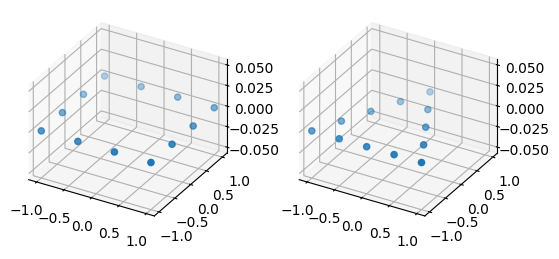

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection = '3d', proj_type = 'ortho')
ax2 = fig.add_subplot(1, 2, 2, projection = '3d', proj_type = 'ortho')
ax1.scatter(rectangle[:, 0], rectangle[:, 1], rectangle[:, 2])
ax2.scatter(triangle[:, 0], triangle[:, 1], triangle[:, 2])
plt.show()

Next, let's define two models with similar structure except that one is equivartiant model.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define a normal shape classifier class using standard fully connected layers
class ShapeClassifierNormal(nn.Module):
    def __init__(self):
        super(ShapeClassifierNormal, self).__init__()
        # First linear layer: input size 36, output size 5
        self.linear1 = nn.Linear(36, 5)
        # Second linear layer: input size 5, output size 2
        self.linear2 = nn.Linear(5, 2)

    def forward(self, x):
        # Pass the input through the first linear layer
        out1 = self.linear1(x)
        # apply nonlinear activation
        out1n = F.leaky_relu(out1)
        # Pass the result through the second linear layer
        out2 = self.linear2(out1n)
        out = F.sigmoid(out2)
        return out/(torch.sum(out) + 1e-9)

# Define an equivariant shape classifier class using e3nn
class ShapeClassifierEquivariant(nn.Module):
    def __init__(self):
        super(ShapeClassifierEquivariant, self).__init__()
        # Define the input irreps: 12 copies of the vector rep
        self.irreps_in = o3.Irreps('12x1o')
        # Define the output irreps: 5 copies of the scalar rep
        self.irreps_out = o3.Irreps('5x0e')
        # Fully connected tensor product
        self.fct = o3.FullyConnectedTensorProduct(self.irreps_in, self.irreps_in, self.irreps_out)
        # Second linear layer: input size 5, output size 2, same as FFNN.
        self.linear = nn.Linear(5, 2)

    def forward(self, x):
        out1 = self.fct(x, x)
        out1n = F.leaky_relu(out1)
        out2 = self.linear(out1n)
        out = F.sigmoid(out2)
        return out/(torch.sum(out) + 1e-9)

Use cross entropy as loss function.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

Create models. If the losses are not going down, it might be because weight initialization might be in a local minima. Restart from this line to get weight re-initialization.

In [ ]:
model_equi = ShapeClassifierEquivariant()
model_norm = ShapeClassifierNormal()

Now we quickly review the neural network structures for the E3NN model.

In [ ]:
model_equi

ShapeClassifierEquivariant(
  (fct): FullyConnectedTensorProduct(12x1o x 12x1o -> 5x0e | 720 paths | 720 weights)
  (linear): Linear(in_features=5, out_features=2, bias=True)
)

and the structure of the fully connected neural networks.



In [ ]:
model_norm

ShapeClassifierNormal(
  (linear1): Linear(in_features=36, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=2, bias=True)
)

Create a training procedure.

In [ ]:
def train(model, data):
    #AdamW optimizer with learning rate 0.01 and weight decay 0.05 to
    # regularize the model and prevent overfitting
    opt = torch.optim.AdamW(model.parameters(), lr = 0.01, weight_decay = 0.05)
    # ExponentialLR scheduler to exponentially decay the learning rate
    # by a factor of 0.96 after each epoch
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma = 0.96)

    losses = []
    for i in range(100):
        model.train()  # Set model to training mode
        round_loss = 0
        for datum in data:
            input, true = datum
            pred = model(input.flatten()) # make prediction
            loss = loss_fn(pred, true) #comput loss function
            round_loss += loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()
        losses.append(round_loss/2)

        if scheduler is not None:
            scheduler.step()

    return losses

Plot the training losses from each model learning. Note that normal model has almost an order magnitude higher number of parameters. So, it is fair to see the lower training loss.

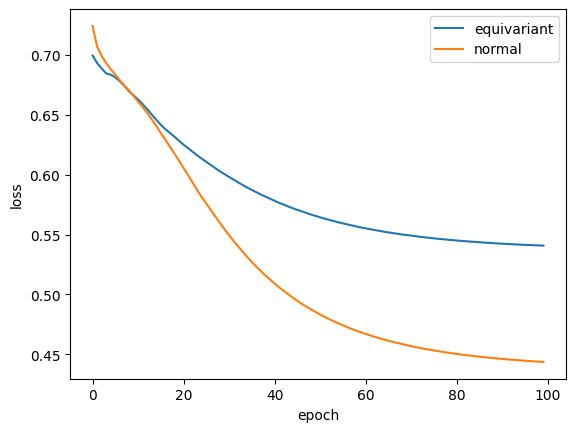

In [ ]:
plt.figure()
plt.plot(train(model_equi, data), label = 'equivariant')
plt.plot(train(model_norm, data), label = 'normal')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

Prediction results from both models on the training input data. We can see that both models are very good at classifying the two input data arrangement.

In [ ]:
print('predicting rectangle with equivariant model (expecting [1.0, 0.0]): ')
print(model_equi(rectangle.flatten()).detach().numpy())
print('\npredicting triangle with equivariant model (expecting [0.0, 1.0]): ')
print(model_equi(triangle.flatten()).detach().numpy())

predicting rectangle with equivariant model (expecting [1.0, 0.0]): 
[0.66004599 0.33995401]

predicting triangle with equivariant model (expecting [0.0, 1.0]): 
[0.32754069 0.67245931]


In [ ]:
print('predicting rectangle with normal neural network model (expecting [1.0, 0.0]): ')
print(model_norm(rectangle.flatten()).detach().numpy())
print('\npredicting triangle with normal neural network model (expecting [0.0, 1.0]): ')
print(model_norm(triangle.flatten()).detach().numpy())

predicting rectangle with normal neural network model (expecting [1.0, 0.0]): 
[0.88016761 0.11983239]

predicting triangle with normal neural network model (expecting [0.0, 1.0]): 
[0.28795462 0.71204538]


Now, we want to see what would happen if we transform the input data by some random rotation.

In [ ]:
irreps_shape = o3.Irreps('12x1o')

In [ ]:
D_shape = irreps_shape.D_from_axis_angle(torch.tensor([1.0, 1.0, 1.0]), torch.tensor(120*np.pi/180))

In [ ]:
rotated_rectangle = (D_shape @ rectangle.flatten()).reshape(-1, 3)
rotated_triangle = (D_shape @ triangle.flatten()).reshape(-1, 3)

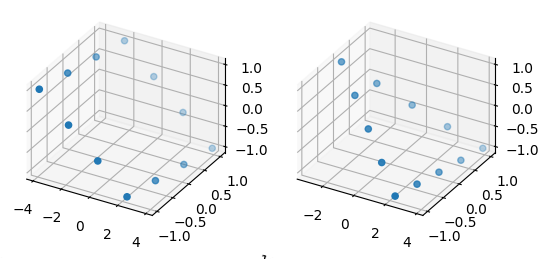

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection = '3d', proj_type = 'ortho')
ax2 = fig.add_subplot(1, 2, 2, projection = '3d', proj_type = 'ortho')
ax1.scatter(rotated_rectangle[:, 0], rotated_rectangle[:, 1], rotated_rectangle[:, 2])
ax2.scatter(rotated_triangle[:, 0], rotated_triangle[:, 1], rotated_triangle[:, 2])
plt.show()

Apply the same models to the rotated inputs. Clearly, the equivariant model maintain its prediction quality. However, the prediction by normal model can degrade or even wrong if the inputs are rotated.

In [ ]:
print('predicting rectangle with equivariant model (expecting [1.0, 0.0]): ')
print(model_equi(rotated_rectangle.flatten()).detach().numpy())
print('\npredicting triangle with equivariant model (expecting [0.0, 1.0]): ')
print(model_equi(rotated_triangle.flatten()).detach().numpy())

predicting rectangle with equivariant model (expecting [1.0, 0.0]): 
[0.66004599 0.33995401]

predicting triangle with equivariant model (expecting [0.0, 1.0]): 
[0.32754069 0.67245931]


In [ ]:
print('predicting rectangle with normal neural network model (expecting [1.0, 0.0]): ')
print(model_norm(rotated_rectangle.flatten()).detach().numpy())
print('\npredicting triangle with normal neural network model (expecting [0.0, 1.0]): ')
print(model_norm(rotated_triangle.flatten()).detach().numpy())

predicting rectangle with normal neural network model (expecting [1.0, 0.0]): 
[0.47002315 0.52997685]

predicting triangle with normal neural network model (expecting [0.0, 1.0]): 
[0.50281942 0.49718058]
